<a href="https://colab.research.google.com/github/crystalloide/Big_Data/blob/master/valeurs_foncieres_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyse des valeurs foncières

Dans sa démarche d'open data, le gouvernement propose un site présentant les données de transactions immobilières enregistrées par les notaires.

Nous allons explorer quelques unes de ces données dans ce notebook, en essayant de combiner une partie de modélisation / ML sur le prix au m², et des outils interactifs de visualisations des transactions, avec le plan suivant:

[1- Téléchargement et analyse des données](#p1)

[2- Géocodage
](#p2)

[3- Analyse des données avec feature géographiques](#p3)

[4- Modélisation](#p4)

Le code complet est disponible sur le github https://github.com/crystalloide/Big_Data



In [1]:
!pip3 install pyproj bokeh>=3.0.0
import os
import math
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyproj import Proj
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool

# Approche moderne pour Bokeh 3.0+ évitant les avertissements d'obsolescence
# Inutile d'importer directement CARTODBPOSITRON : on utilise add_tile avec le nom du provider.

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# output_notebook()

In [3]:
### Les fonctions utiles dont le data cleansing
def show_cols(df):
  """ show summary of a dataframe """
  print(" Colonnes dans le fichier :\n " + "-"*20 + "\n" +  "\n".join(["{:2d} || {:30s} : {} ".format(k,n,t) for k,(n,t) in enumerate(zip(df.columns,df.dtypes))]))
  print ("-"*20)
  print(" Nombres de transaction enregistrées : \n " + "-"*20 + "\n{}".format(len(df)))

def process_string(s):
  """ Changer la virgule en point pour les problèmes de convention flottante française
  """
  if isinstance(s, str):
    return float(s.replace(',', '.'))
  else:
    return s

def clean_str_nan(s):
  """ supprimer les valeurs flottantes et les colonnes de type chaîne avec aucune donnée("nan")
  """
  if isinstance(s, float) and np.isnan(s):
      return ""
  return s


def remove_out(d, nsigma=2):
  """ Suppressions des valeurs aberrantes d'une distribution
  input:
    d (pd.DataFrame) : Dataframe
    nsigma (int) : number of std deviation to allow around median

  output:
    df (pd.DataFrame): filtered Dataframe
    selec (bool) : boolean list such as df = d[selec]

  """
  m = d.median()
  s = np.abs(d-m).median()
  selec = (d<=(m+nsigma*s)) & (d>=(m-nsigma*s))
  return d[selec], selec

  ##Geocoding
def line_to_location_string(serie):
  """ Combine les différents champs du dataframe en une adresse cohérente
  """
  number = serie["No voie"]
  if number.is_integer():
    number = str(int(number))
  else:
    number = ""
  return ", ".join(["France", \
      serie["Commune"], \
      ("%05i" % (serie["Code postal"],)), \
        " ".join([ number, serie["Type de voie"], serie["Voie"]])])

def get_all_location_string(df):
  """ Renvoie les adresses uniques dans le dataframe
  """
  location = df.apply(line_to_location_string, axis=1)
  return location.unique()

# Création d'un affichage :
def create_map_plot(data):
  # Créer une nouvelle figure avec une projection de Mercator (requis pour les cartes)
  p = figure(
      x_axis_type="mercator",
      y_axis_type="mercator",
      active_scroll="wheel_zoom"
  )

  # Source de la tuile - pas besoin d'importer CARTODBPOSITRON au préalable
  p.add_tile("CARTODBPOSITRON")

  # Reste du code pour le tracé ici, si besoin
  return p


### Liste des Liens vers les fichiers disponibles :

#### Source https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/
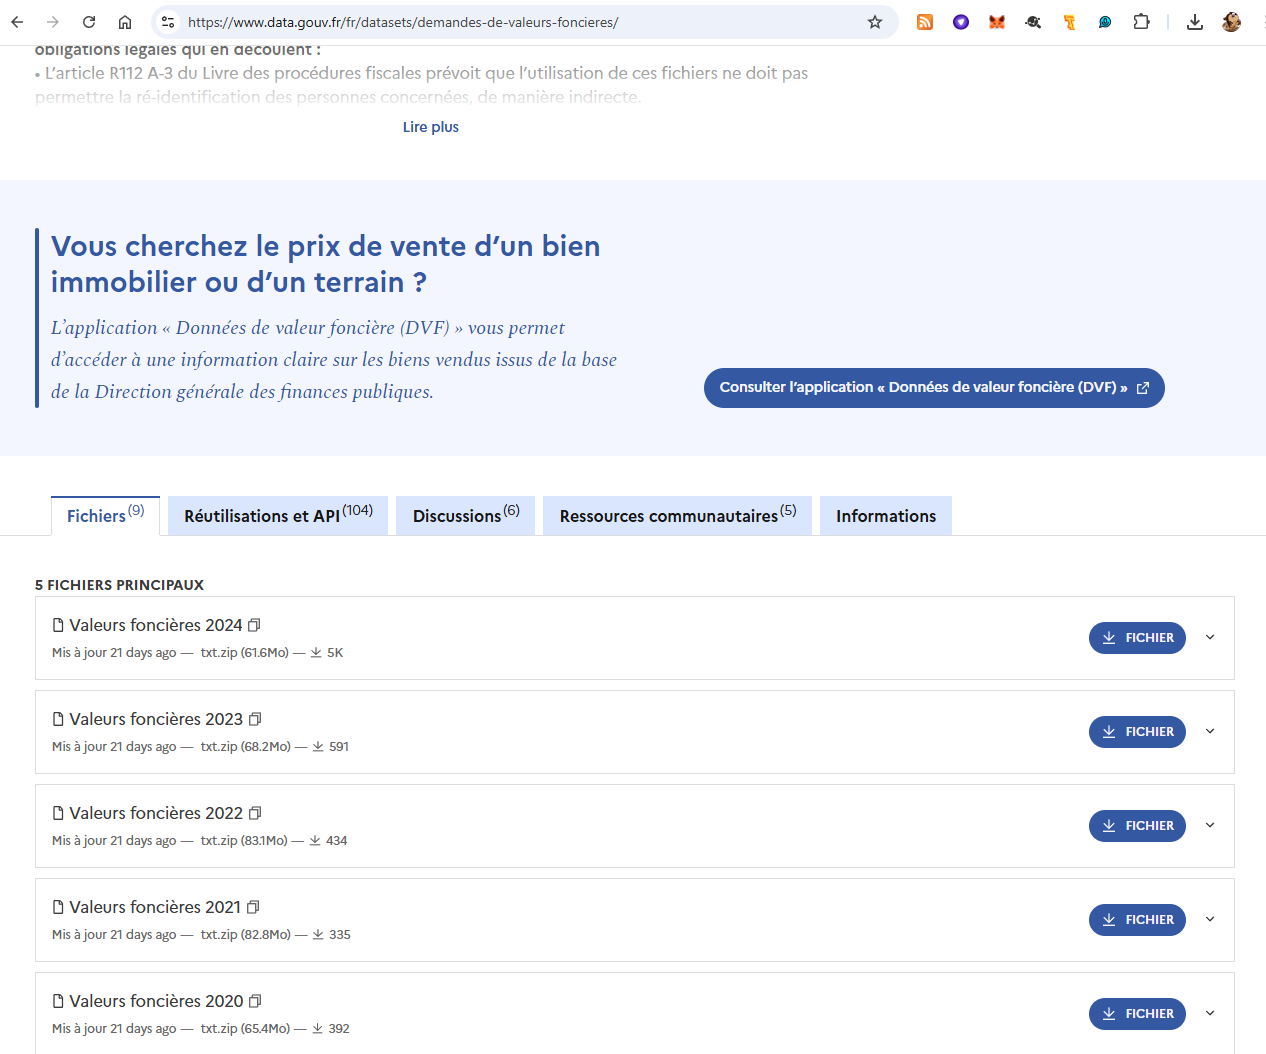

#### Dataset year='2024' size='61 Mo'

####Identifiant= '5ffa8553-0e8f-4622-add9-5c0b593ca1f8'

URL stable : 'https://www.data.gouv.fr/fr/datasets/r/5ffa8553-0e8f-4622-add9-5c0b593ca1f8'

link='https://www.data.gouv.fr/fr/datasets/r/5ffa8553-0e8f-4622-add9-5c0b593ca1f8'


Dataset year='2023' size='68 Mo'

Identifiant ='bc213c7c-c4d4-4385-bf1f-719573d39e90'

URL stable ='https://www.data.gouv.fr/fr/datasets/r/bc213c7c-c4d4-4385-bf1f-719573d39e90'

link='https://www.data.gouv.fr/fr/datasets/r/bc213c7c-c4d4-4385-bf1f-719573d39e90'


Dataset year='2019' size='130 Mo'
link='https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2'

Dataset year='2018' size='297 Mo'
link='https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346'

Dataset year='2017' size='428 Mo'
link='https://www.data.gouv.fr/fr/datasets/r/7161c9f2-3d91-4caf-afa2-cfe535807f04'

Dataset year='2016' size='373 Mo'
link='https://www.data.gouv.fr/fr/datasets/r/0ab442c5-57d1-4139-92c2-19672336401c'

## 1 - Téléchargement et analyse

In [4]:
!rm valeursfoncieres-2024.txt.zip
!rm ValeursFoncieres-2024.txt

# Fichier officiel en ligne :
!wget 'https://static.data.gouv.fr/resources/demandes-de-valeurs-foncieres/20250406-003043/valeursfoncieres-2024.txt.zip'
!ls
# On dézipe :
!unzip valeursfoncieres-2024.txt.zip


# Copie disponible dans mon drive :
# file_id = '13Tcjs7ut-cBOEK46rMQ7OTANuk9kOmsz'
#
# fn = 'ValeursFoncieres-2024.txt'
#
#download_link = f'https://drive.google.com/uc?export=download&id={file_id}'
#
# !wget "{download_link}" -O "{fn}"

!ls
fname = 'ValeursFoncieres-2024.txt'

# fid = open(fname, 'r', encoding='utf-8') # Open the file with 'utf-8' encodi
fid = open(fname, 'r')
df=pd.read_csv(fname, sep='|', low_memory=False)
fid.close()

rm: cannot remove 'valeursfoncieres-2024.txt.zip': No such file or directory
rm: cannot remove 'ValeursFoncieres-2024.txt': No such file or directory
--2025-05-17 15:54:00--  https://static.data.gouv.fr/resources/demandes-de-valeurs-foncieres/20250406-003043/valeursfoncieres-2024.txt.zip
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.73, 37.59.183.91
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64633591 (62M) [application/zip]
Saving to: ‘valeursfoncieres-2024.txt.zip’

valeursfoncieres-20 100%[===================>]  61.64M  17.4MB/s    in 4.7s    

2025-05-17 15:54:05 (13.1 MB/s) - ‘valeursfoncieres-2024.txt.zip’ saved [64633591/64633591]

'=3.0.0'   sample_data	 valeursfoncieres-2024.txt.zip
Archive:  valeursfoncieres-2024.txt.zip
  inflating: ValeursFoncieres-2024.txt  
'=3.0.0'       ValeursFoncieres-2024.txt
 sample_data   valeursfoncieres-2024.txt.zip


###a- Filtrage


In [5]:
show_cols(df)

 Colonnes dans le fichier :
 --------------------
 0 || Identifiant de document        : float64 
 1 || Reference document             : float64 
 2 || 1 Articles CGI                 : float64 
 3 || 2 Articles CGI                 : float64 
 4 || 3 Articles CGI                 : float64 
 5 || 4 Articles CGI                 : float64 
 6 || 5 Articles CGI                 : float64 
 7 || No disposition                 : int64 
 8 || Date mutation                  : object 
 9 || Nature mutation                : object 
10 || Valeur fonciere                : object 
11 || No voie                        : float64 
12 || B/T/Q                          : object 
13 || Type de voie                   : object 
14 || Code voie                      : object 
15 || Voie                           : object 
16 || Code postal                    : float64 
17 || Commune                        : object 
18 || Code departement               : object 
19 || Code commune                   : int64 
20 

In [6]:
print(df.columns)

Index(['Identifiant de document', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='object')


Il convient d'abord de faire un tri parmi les colonnes, en ne gardant que celles d'intérêt à notre étude dans un premier temps, et en reformatant les contenus pour des types plus homogènes

In [7]:
# Reformatage des colonnes qui devraient être des nombres flottants
key_to_proc = ("Valeur fonciere", "Surface reelle bati", "Code postal")
df = df.assign(**{key: df[key].apply(process_string) for key in key_to_proc})

# Renommage des colonnes
df = df.rename(columns={"Surface reelle bati": "surface", "Valeur fonciere": "prix"})

# Traitement du code postal
df = df.assign(
    **{"Code postal": df["Code postal"].fillna(-9999).astype(int)}
)

# Reformatage des colonnes qui devraient être des chaînes
df = df.assign(
    **{
        "Type de voie": df["Type de voie"].apply(clean_str_nan),
        "Voie": df["Voie"].apply(clean_str_nan)
    }
)

# Sélection des colonnes d'intérêt
keys_of_interest = ["surface", "prix", "Type de voie", "Voie", "Code postal", "Type local", "Code departement", "Commune", "No voie"]
df = df[keys_of_interest]

# Suppression des lignes avec valeurs manquantes
keys_of_no_na = ["surface", "prix"]
df = df.dropna(subset=keys_of_no_na)

# Suppression des lignes avec surface nulle ou négative
df = df[df["surface"] > 0]

# Ajout de la colonne ratio
df = df.assign(**{"prix au m2": df["prix"] / df["surface"]})

# Affichage des colonnes
show_cols(df)
print(df.head(10))

 Colonnes dans le fichier :
 --------------------
 0 || surface                        : float64 
 1 || prix                           : float64 
 2 || Type de voie                   : object 
 3 || Voie                           : object 
 4 || Code postal                    : int64 
 5 || Type local                     : object 
 6 || Code departement               : object 
 7 || Commune                        : object 
 8 || No voie                        : float64 
 9 || prix au m2                     : float64 
--------------------
 Nombres de transaction enregistrées : 
 --------------------
1086696
    surface      prix Type de voie                   Voie  Code postal  \
6      89.0  329500.0           PL                DU JURA         1170   
78     74.0   94500.0          RUE  DES PETITES FONTAINES         1150   
80     32.0   94500.0          RUE  DES PETITES FONTAINES         1150   
81     40.0  220000.0                          AU MOLLARD         1640   
82     80.0  220

Pour le moment, on sélectionne seulement les appartements parisiens

In [8]:
# Créer un filtre pour les appartements à Paris
selec = (df["Type local"] == "Appartement") & (df["Code departement"] == "75")

# remove_out() est une fonction personnalisée pour enlever les valeurs aberrantes
# Appliquer cette fonction uniquement sur les données filtrées
prix_paris, subselec_paris = remove_out(df.loc[selec, "prix au m2"])

# Mettre à jour le filtre original en tenant compte des valeurs aberrantes supprimées
# Créer un tableau booléen de même taille que le filtre original, initialisé à False
filtre_final = pd.Series(False, index=selec.index)

# Mettre à True les indices qui sont True dans selec et qui ne sont pas des valeurs aberrantes
filtre_final.loc[selec] = subselec_paris

# Créer le dataframe final
paris_df = df.loc[filtre_final].copy()

print(paris_df.head(10))

# Sauvegarder en pickle
paris_df.to_pickle("paris_dataframe.pkl")
paris_df.to_pickle("paris_df.pkl")

         surface       prix Type de voie                Voie  Code postal  \
3384366     86.0  1042000.0          VLA             PERREUR        75020   
3384369     36.0   299120.0          RUE      DU ROI D ALGER        75018   
3384370     42.0   426471.0           AV          PARMENTIER        75010   
3384371     60.0   778000.0          RUE   VIEILLE DU TEMPLE        75003   
3384372     63.0   778000.0          RUE   VIEILLE DU TEMPLE        75003   
3384375     66.0   630000.0         QUAI         DE LA SEINE        75019   
3384377     17.0   173025.0          RUE  DE L ADJUDANT REAU        75020   
3384380     40.0   392000.0          RUE       ARTHUR ROZIER        75019   
3384381     22.0   160000.0           AV           DE CLICHY        75017   
3384385     26.0   228000.0          RUE              LETORT        75018   

          Type local Code departement   Commune  No voie    prix au m2  
3384366  Appartement               75  PARIS 20      4.0  12116.279070  
338436

### a- bis Chargement d'un pickle existant (optionnel)


In [ ]:
import pickle
file_id = '1UsUscZVphFb6gqLDvaNL8BWcIg6jqFrf'
fn = "paris_dataframe.pkl"

# Construct the direct download link
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

!wget "{download_link}" -O "{fn}"

try:
  with open(fn, 'rb') as file:
    paris_df = pickle.load(file)
  print("{name} loaded correctly as {type}".format(name=fn, type=type(paris_df)))
except Exception as exc:
  print("failed to load {} (not a pickle ?)".format(fn))
  raise exc
print(paris_df.head(10))

--2025-04-26 20:39:56--  https://drive.google.com/uc?export=download&id=1UsUscZVphFb6gqLDvaNL8BWcIg6jqFrf
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.102, 142.251.2.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1UsUscZVphFb6gqLDvaNL8BWcIg6jqFrf&export=download [following]
--2025-04-26 20:39:56--  https://drive.usercontent.google.com/download?id=1UsUscZVphFb6gqLDvaNL8BWcIg6jqFrf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1652953 (1.6M) [application/octet-stream]
Saving to: ‘paris_dataframe.pkl’

paris_dataframe.pkl 100%[===================>]   1.58M  --.-K

In [9]:
display(paris_df.count())

,0
surface,23394
prix,23394
Type de voie,23394
Voie,23394
Code postal,23394
Type local,23394
Code departement,23394
Commune,23394
No voie,23394
prix au m2,23394


### b- Analyse

On a à présent un subset des prix des appartements parisiens les plus représentatifs.

On peut commencer par regarder la répartition des prix, à l'échelle de la ville :

Histogramme des prix au m²


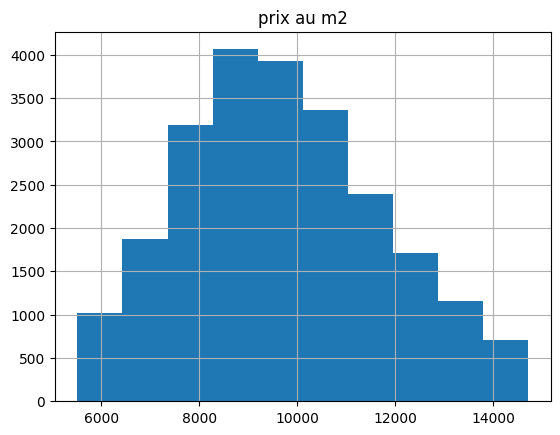

In [10]:
print("Histogramme des prix au m²")
_ = paris_df.hist(column="prix au m2")

Et des arrondissements :

<Axes: xlabel='Code postal'>

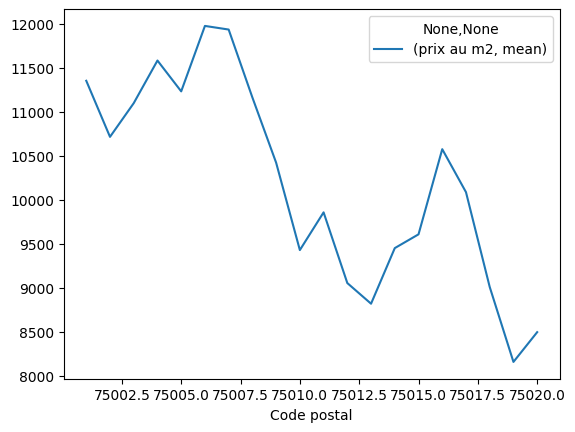

In [11]:
paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["mean"]).plot()

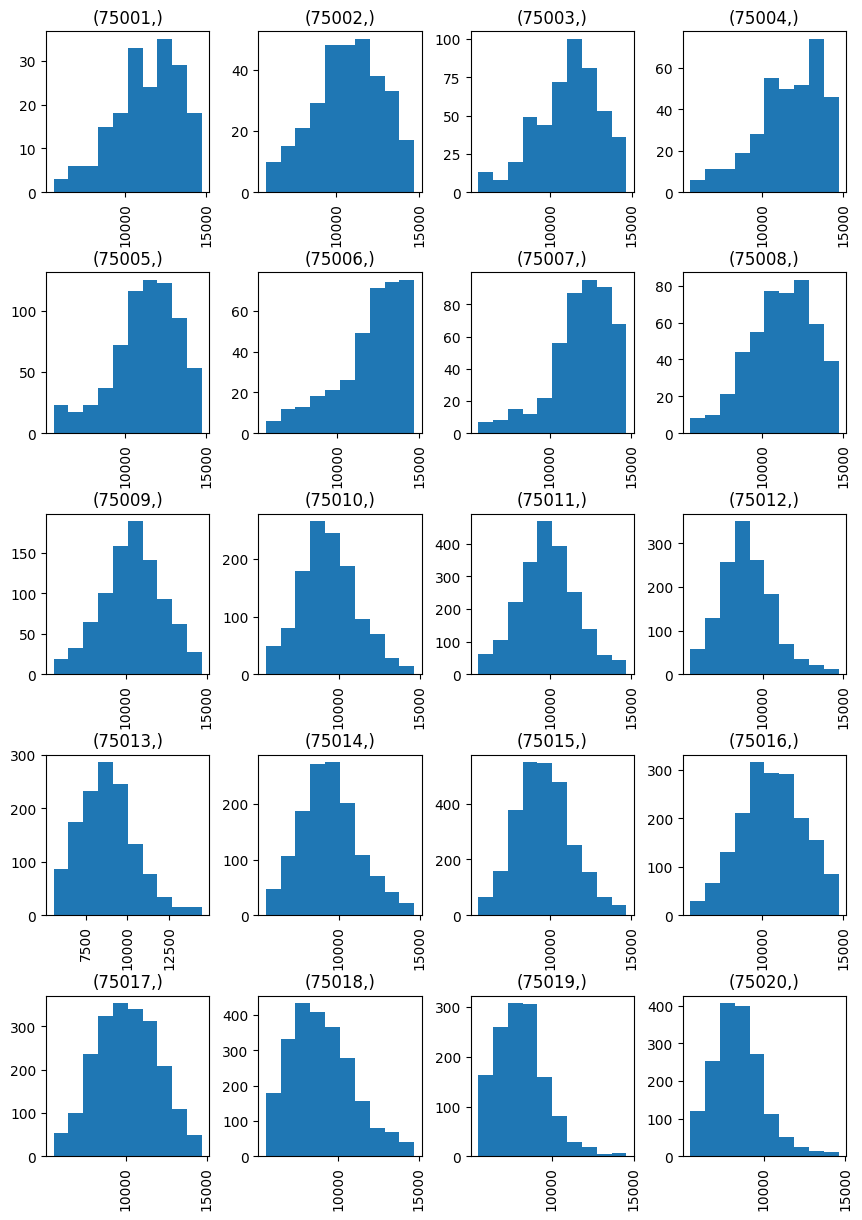

In [12]:
_=paris_df.hist(column="prix au m2", by=["Code postal"], figsize=(10,15))

Outre la variation des prix par arrondissement, qui colle bien avec le marché immobilier, on remarque deux choses :

1.   la répartition des prix dans chaque arrondissement semble bien normalement distribuée
2.   on manque de données pour le 1e et 2e arrondissement

Regardons pour finir le classement des arrondissements du plus onéreux au moins cher :



In [13]:
#print(paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["count"]))
print("Classement des arrondissements par prix au m²:")
print(paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["mean"]).sort_values(by=("prix au m2", "mean"), ascending=False))

Classement des arrondissements par prix au m²:
               prix au m2
                     mean
Code postal              
75006        11976.519989
75007        11935.252351
75004        11582.850604
75001        11352.524624
75005        11232.067360
75008        11162.415726
75003        11097.962365
75002        10714.568733
75016        10574.400383
75009        10420.959815
75017        10085.501010
75011         9855.866449
75015         9605.721215
75014         9449.129120
75010         9426.755808
75012         9051.560636
75018         9007.289695
75013         8816.677937
75020         8493.102113
75019         8154.478762


<a id='p2'> </a>

##2- Géocoding

#### Pour commencer des modélisations allant au delà des attributs statistiques standards,
#### il est nécessaire d'enrichir les données pour leur ajouter une composante spatiale exploitable.

#### On s'appuie ici sur l'API Mapquest pour transformer les adresses en coordonnées UTM.

#### Comme précédemment, on peut passer cette étape en uploadant directement le résultat s'il est disponible

In [14]:
all_loc = get_all_location_string(paris_df)

### Complément des informations avec les données MapQuest (passer si upload possible)
Requête des données sur MapQuest

#### Comment obtenir une clé API pour MapQuest Geocoding (payant)

#### Étapes à suivre :

Rendez-vous sur le site des développeurs MapQuest à l’adresse suivante : https://developer.mapquest.com/documentation.

Créez un compte MapQuest si vous n’en possédez pas déjà un. L’inscription est gratuite.

Une fois inscrit et connecté, une clé API vous sera automatiquement fournie. Cette clé est nécessaire pour accéder aux services MapQuest, y compris l’API de géocodage.

Utilisez cette clé API dans vos requêtes vers l’API de géocodage MapQuest.

Si vous utilisez déjà une clé pour les cartes de base MapQuest, elle fonctionne également pour la géocodification.



In [ ]:
# Test de la clé API :
key = input("input API key: \n")
#key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
#print (key)
!curl -I "https://www.mapquestapi.com/geocoding/v1/batch?key={key}&location=Paris&location=Lyon"


In [ ]:
import os
import math
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists("batches"):
  os.mkdir("batches")

# key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
key = input("input API key: \n")
#print (key)
url = "https://www.mapquestapi.com/geocoding/v1/batch?key="
url = url+key
#print (url)

def submit_data(locations):
    """ Use mapquest api to request GPS coordinates from the address
    """
    print ("submit_data")
    dico = {"maxResults":1, "location":locations, "key":key}
    #dico = {"maxResults":1, "location":locations}

    req = requests.get(url, params=dico)
    return json.loads(req.text)['results']
    # Check if the request was successful


def batch_maker(loc_list, batch_size=100):
  """ generate batches of batch_size adresses to feed the batch API
  """
  print ("batch_maker")
  n_batch = int(math.ceil(len(loc_list) / batch_size))
  for k_batch in range(n_batch):
    yield loc_list[k_batch*batch_size:min((k_batch+1)*batch_size, len(loc_list))]

  for kb, batch in enumerate(batch_maker(all_loc)):
      gps_loc = submit_data(batch)
    # If submit_data encountered an error, skip this batch
      if gps_loc is None:
          print(f"Skipping batch {kb} due to error.")
          continue

  latlong = [ a["locations"][0]["latLng"] for a in gps_loc]
  batch_lat = [a["lat"] for a in latlong]
  batch_long = [a["lng"] for a in latlong]
  batch_df=pd.DataFrame({"location":batch, "lat":batch_lat, "long":batch_long})
  batch_df.to_pickle("batches/batch_{}.pkl".format(kb))

blist = os.listdir("batches")
all_df = None
for bfile in blist:
  batch_df = pd.read_pickle("batches/"+bfile)
  if all_df is None:
    all_df = batch_df
  else:
    all_df = pd.concat((all_df, batch_df), ignore_index=True)
all_df.to_pickle("paris_unique_locations_df.pkl")
print(all_df.head(10))

### Upload (optionnel : à faire si vous n'avez pas de clé API)

In [15]:
import pickle
file_id = '12JKAsMBeAsdQsmPYhKv2ikcRx6P9ME66'
fn = "paris_unique_locations_df.pikl"

# Construct the direct download link
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

!wget "{download_link}" -O "{fn}"

try:
  with open(fn, 'rb') as file:
    all_df = pickle.load(file)
  print("{name} loaded correctly as {type}".format(name=fn, type=type(all_df)))
except Exception as exc:
  print("failed to load {} (not a pickle ?)".format(fn))
  raise exc
print(all_df.head(10))

--2025-05-17 15:57:23--  https://drive.google.com/uc?export=download&id=12JKAsMBeAsdQsmPYhKv2ikcRx6P9ME66
Resolving drive.google.com (drive.google.com)... 142.250.141.113, 142.250.141.102, 142.250.141.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12JKAsMBeAsdQsmPYhKv2ikcRx6P9ME66&export=download [following]
--2025-05-17 15:57:23--  https://drive.usercontent.google.com/download?id=12JKAsMBeAsdQsmPYhKv2ikcRx6P9ME66&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4878 (4.8K) [application/octet-stream]
Saving to: ‘paris_unique_locations_df.pikl’

paris_unique_locati 100%[===================>] 

<a id='p3'> </a>

### Visualisation


Pour la visualisation, on commence par projeter les lat/long en UTM WebM, puis on fusionne les adresses et les coordonnées géograpgiques

In [16]:
!pip install contextily
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 80.4 MB/s eta 0:00:00


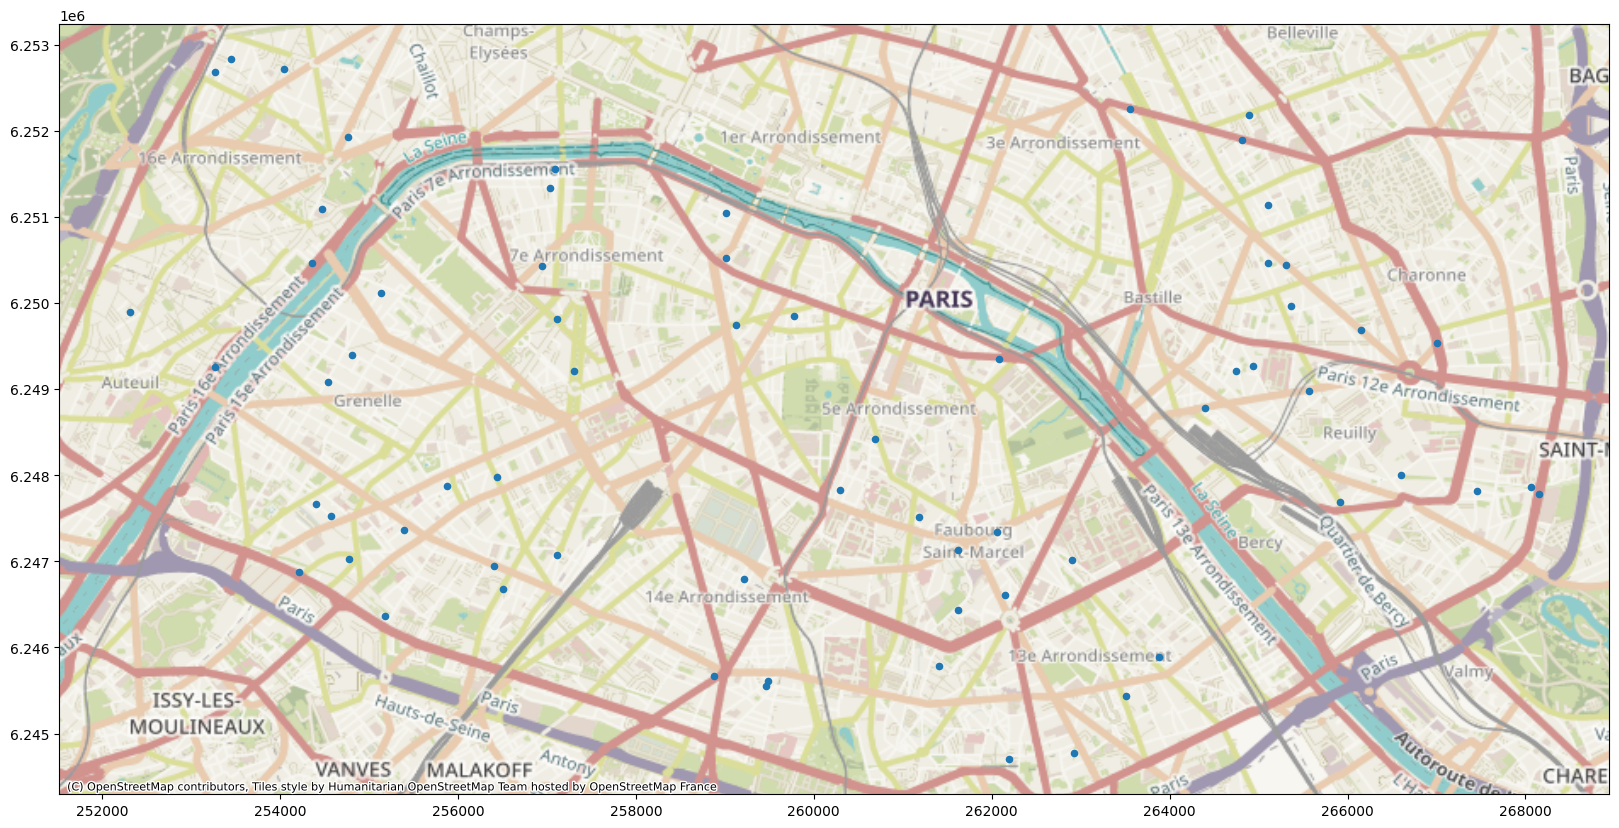

In [18]:
import contextily as ctx


#projection web mercator
projo = Proj('epsg:3857') # Corrected initialization
selec = remove_out(all_df["long"], nsigma=10)[1] * remove_out(all_df["lat"], nsigma=10)[1]
x, y = projo(all_df["long"][selec].values, all_df["lat"][selec].values)
lo, la = all_df["long"][selec].values, all_df["lat"][selec].values

# Create the scatter plot
fig, ax = plt.subplots(figsize=(20, 10))  # Adjust figure size as needed
ax.scatter(x, y, s=20)  # Adjust marker size as needed

# Add basemap
ctx.add_basemap(ax, crs='epsg:3857')

plt.show()

On a bien quelque chose qui ressemble à Paris.
On intègre maintenant ces coordonnées à la base de valeurs immobilières:

In [19]:
display(paris_df.sample(10))

,surface,prix,Type de voie,Voie,Code postal,Type local,Code departement,Commune,No voie,prix au m2
3418687,171.0,2300000.0,RUE,D ASSAS,75006,Appartement,75,PARIS 06,28.0,13450.292398
3431029,92.0,850000.0,RUE,DU THEATRE,75015,Appartement,75,PARIS 15,104.0,9239.130435
3417809,14.0,145325.0,RUE,DOUDEAUVILLE,75018,Appartement,75,PARIS 18,70.0,10380.357143
3403177,32.0,210000.0,RUE,CONDORCET,75009,Appartement,75,PARIS 09,50.0,6562.500000
3390643,110.0,1290700.0,AV,DE CLICHY,75017,Appartement,75,PARIS 17,3.0,11733.636364
3448296,44.0,333000.0,RUE,SERRET,75015,Appartement,75,PARIS 15,4.0,7568.181818
3410556,19.0,255000.0,RUE,DE PICARDIE,75003,Appartement,75,PARIS 03,16.0,13421.052632
3423026,41.0,384000.0,RUE,DU LOING,75014,Appartement,75,PARIS 14,16.0,9365.853659
3433343,110.0,1155000.0,RUE,CHALGRIN,75016,Appartement,75,PARIS 16,14.0,10500.000000
3400105,90.0,805000.0,BD,DE CLICHY,75018,Appartement,75,PARIS 18,2.0,8944.444444


In [20]:
paris_df["location"] = paris_df.apply(line_to_location_string, axis=1)
all_df = all_df[selec]
all_df["X"] = x
all_df["Y"] = y

paris_df = pd.merge(paris_df, all_df,  on="location", how="inner")


In [21]:
display(paris_df.sample(10))

,surface,prix,Type de voie,Voie,Code postal,Type local,Code departement,Commune,No voie,prix au m2,location,lat,long,X,Y
5,28.0,320000.0,RUE,HENRI BARBUSSE,75005,Appartement,75,PARIS 05,37.0,11428.571429,"France, PARIS 05, 75005, 37 RUE HENRI BARBUSSE",48.84045,2.33828,260296.138932,6.247832e+06
14,72.0,619500.0,RUE,DU SAHEL,75012,Appartement,75,PARIS 12,61.0,8604.166667,"France, PARIS 12, 75012, 61 RUE DU SAHEL",48.84064,2.40804,268061.786610,6.247864e+06
66,20.0,200000.0,RUE,DE LA GARE DE REUILLY,75012,Appartement,75,PARIS 12,20.0,10000.000000,"France, PARIS 12, 75012, 20 RUE DE LA GARE DE ...",48.84144,2.39490,266599.048501,6.248000e+06
45,29.0,260000.0,BD,DE CHARONNE,75011,Appartement,75,PARIS 11,25.0,8965.517241,"France, PARIS 11, 75011, 25 BD DE CHARONNE",48.85051,2.39853,267003.138252,6.249534e+06
7,135.0,886970.0,RUE,LABROUSTE,75015,Appartement,75,PARIS 15,6.0,6570.148148,"France, PARIS 15, 75015, 6 RUE LABROUSTE",48.83594,2.30970,257114.627885,6.247070e+06
28,102.0,1060000.0,RUE,DU GAL APPERT,75016,Appartement,75,PARIS 16,20.0,10392.156863,"France, PARIS 16, 75016, 20 RUE DU GAL APPERT",48.86914,2.27517,253270.765868,6.252686e+06
47,45.0,377000.0,RUE,DE CHARENTON,75012,Appartement,75,PARIS 12,203.0,8377.777778,"France, PARIS 12, 75012, 203 RUE DE CHARENTON",48.83962,2.38876,265915.546827,6.247692e+06
0,110.0,1600800.0,RUE,DE LA POMPE,75016,Appartement,75,PARIS 16,150.0,14552.727273,"France, PARIS 16, 75016, 150 RUE DE LA POMPE",48.86934,2.28215,254047.775914,6.252720e+06
44,60.0,631800.0,BD,VOLTAIRE,75011,Appartement,75,PARIS 11,160.0,10530.000000,"France, PARIS 11, 75011, 160 BD VOLTAIRE",48.85587,2.38335,265313.308382,6.250441e+06
15,32.0,180000.0,RUE,SAINT JACQUES,75005,Appartement,75,PARIS 05,246.0,5625.000000,"France, PARIS 05, 75005, 246 RUE SAINT JACQUES",48.84390,2.34183,260691.323124,6.248416e+06


Les données sont prêtes !

In [22]:
x, y, p = paris_df["X"].values, paris_df["Y"].values, paris_df["prix au m2"].values
selec = (x>0) * (y>0)
x = x[selec]
y = y[selec]
p = p[selec]

x_range, y_range = ((min(x),max(x)), (min(y),max(y)))

### Plotting
plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
  """ setup a bokeh plot
  """
  p = figure(tools=tools, width=plot_width, height=plot_height,
      x_range=x_range, y_range=y_range, outline_line_color=None,
      min_border=0, min_border_left=0, min_border_right=0,
      min_border_top=0, min_border_bottom=0, **plot_args)

  p.axis.visible = False
  p.xgrid.grid_line_color = None
  p.ygrid.grid_line_color = None
  p.add_tools(BoxZoomTool(match_aspect=True))
  return p

pl = base_plot()
pl.add_tile("CARTODBPOSITRON")
subsamp=1
source = ColumnDataSource(data={
    'x' : x[::subsamp],
    'y' : y[::subsamp],
    'address':paris_df["location"][selec][::subsamp],
    'prix':paris_df["prix au m2"][selec][::subsamp],
    'surface':paris_df["surface"][selec][::subsamp],
    'color':[
    "#%02x%02x%02x" % (int(p*255), int(p*255), int(p*255)) for p in (1-(p[::subsamp]-p.min())/(p.max()-p.min()))
]
})

pl.circle(x="x", y="y", radius=50, fill_color="color", line_color="Green", source=source)

pl.add_tools(HoverTool(
    tooltips=[
        ( 'address', '@address'      ),
        ( 'prix', '@prix{i} € au m²'      ),
        ('surface', '@surface m²')
    ]))

show(pl)

<a id='p4'> </a>

### Modélisation


Pour modéliser les données, on utilise une régression par vecteur de support avec noyau gaussien.

Le paramètre gamma nous permet de jouer sur le lissage géographique du modèle



In [23]:
scaler = StandardScaler()

feature = scaler.fit_transform(np.array([x, y]).T)
target = p

clf = SVR(kernel='rbf', gamma=10, C=100
          , epsilon=500, max_iter=-1)
clf.fit(feature, target)


SVR(C=100, epsilon=500, gamma=10)

Voyons à quoi ressemble notre modèle :

In [24]:
# nsamp = 400
nsamp = 500
x_reg = np.linspace(x.min(), x.max(), nsamp)
y_reg = np.linspace(y.min(), y.max(), nsamp)
xx, yy = np.meshgrid(x_reg, y_reg)
pp = griddata((x,y), p, (xx,yy))

pp = clf.predict(scaler.transform(np.array([np.ravel(xx), np.ravel(yy)]).T))
pp.shape = (nsamp,nsamp)


# Import necessary modules
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, BoxZoomTool
# from bokeh.tile_providers import CARTODBPOSITRON # This module is no longer available in Bokeh 3+
from bokeh.models import WMTSTileSource
from bokeh.io import output_notebook, show

#Instead of OpenStreetMap, we can use the built in CARTODBPOSITRON using the following URL:
#url = "http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png"
url = "https://tiles.basemaps.cartocdn.com/rastertiles/voyager/{Z}/{X}/{Y}.png"


pl = base_plot()
pl.add_tile("CARTODBPOSITRON")
pl.image(image=[pp], x=x.min(), y=y.min(), dw=x.max()-x.min(), dh=y.max()-y.min(), global_alpha=0.3, palette="Spectral11")
pl.add_tools(HoverTool(
    tooltips=[
        ( 'prix', '@image{i} €'      ),
    ]))
show(pl)

### Visualisation interactive avec datashader

(Cette partie est en corus de finalisation)

In [25]:
!pip3 install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.0 MB/s eta 0:00:00


In [26]:
display(paris_df.head(10))

,surface,prix,Type de voie,Voie,Code postal,Type local,Code departement,Commune,No voie,prix au m2,location,lat,long,X,Y
0,110.0,1600800.0,RUE,DE LA POMPE,75016,Appartement,75,PARIS 16,150.0,14552.727273,"France, PARIS 16, 75016, 150 RUE DE LA POMPE",48.86934,2.28215,254047.775914,6.252720e+06
1,17.0,109599.0,RUE,BRANCION,75015,Appartement,75,PARIS 15,45.0,6447.000000,"France, PARIS 15, 75015, 45 RUE BRANCION",48.83365,2.30426,256509.049855,6.246682e+06
2,30.0,374000.0,RUE,DE GRIBEAUVAL,75007,Appartement,75,PARIS 07,5.0,12466.666667,"France, PARIS 07, 75007, 5 RUE DE GRIBEAUVAL",48.85634,2.32671,259008.172424,6.250520e+06
3,33.0,280000.0,RUE,JEAN MACE,75011,Appartement,75,PARIS 11,9.0,8484.848485,"France, PARIS 11, 75011, 9 RUE JEAN MACE",48.85305,2.38377,265360.062568,6.249964e+06
4,21.0,210000.0,IMP,DU ROUET,75014,Appartement,75,PARIS 14,7.0,10000.000000,"France, PARIS 14, 75014, 7 IMP DU ROUET",48.82769,2.32556,258880.155009,6.245674e+06
5,28.0,320000.0,RUE,HENRI BARBUSSE,75005,Appartement,75,PARIS 05,37.0,11428.571429,"France, PARIS 05, 75005, 37 RUE HENRI BARBUSSE",48.84045,2.33828,260296.138932,6.247832e+06
6,43.0,367000.0,RUE,DE DOMREMY,75013,Appartement,75,PARIS 13,46.0,8534.883721,"France, PARIS 13, 75013, 46 RUE DE DOMREMY",48.82894,2.37046,263878.400146,6.245886e+06
7,135.0,886970.0,RUE,LABROUSTE,75015,Appartement,75,PARIS 15,6.0,6570.148148,"France, PARIS 15, 75015, 6 RUE LABROUSTE",48.83594,2.30970,257114.627885,6.247070e+06
8,34.0,294790.0,BD,VOLTAIRE,75011,Appartement,75,PARIS 11,227.0,8670.294118,"France, PARIS 11, 75011, 227 BD VOLTAIRE",48.85140,2.39089,266152.657343,6.249685e+06
9,29.0,298720.0,RUE,ALPHAND,75013,Appartement,75,PARIS 13,22.0,10300.689655,"France, PARIS 13, 75013, 22 RUE ALPHAND",48.82831,2.34828,261409.333840,6.245779e+06


In [27]:
# import os
# os.environ["NUMBA_CUDA_DRIVER"] = "/usr/local/cuda/lib64/libcuda.so.1"
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9
from colorcet import fire, rainbow
from bokeh.plotting import figure, show
from bokeh.models import WMTSTileSource, HoverTool

# Définition des plages de valeurs (à adapter selon tes données)
x_range = (paris_df['X'].min(), paris_df['X'].max())
y_range = (paris_df['Y'].min(), paris_df['Y'].max())

cvs = ds.Canvas(plot_width=25, plot_height=25, x_range=x_range, y_range=y_range)
agg = cvs.points(paris_df, 'X', 'Y', ds.mean('prix au m2'))

if agg.coords["X"].size > 0 and agg.coords["Y"].size > 0:
    xc = np.linspace(agg.coords["X"].min().item(), agg.coords["X"].max().item(), 1000)
    yc = np.linspace(agg.coords["Y"].min().item(), agg.coords["Y"].max().item(), 1000)

    aggi = agg.interp(dict(Y=yc, X=xc), method='linear')
    imgi = tf.shade(aggi, cmap=rainbow)

    # Création du graphique
    pl = figure(title="Prix au m2 à Paris", x_range=x_range, y_range=y_range)
    url = "http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png"
    #url = "https://tiles.basemaps.cartocdn.com/rastertiles/voyager/{Z}/{X}/{Y}.png"

    pl.add_tile(WMTSTileSource(url=url))
#    pl.add_tile("CARTODBPOSITRON")

    pl.image(image=[aggi.values], x=x_range[0], y=y_range[0], dw=x_range[1] - x_range[0], dh=y_range[1] - y_range[0], global_alpha=0.3,
             palette="Spectral11")  # Assure-toi que cette palette existe dans Bokeh

    pl.add_tools(HoverTool(tooltips=[('Prix/m2', '@image{0.00} €')]))  # Format numérique ajusté

    show(pl)
else:
    print("Aucun point de données trouvé dans la plage spécifiée.")


In [28]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9
from colorcet import fire, rainbow

cvs = ds.Canvas(plot_width=25, plot_height=25, x_range=x_range, y_range=y_range)
agg = cvs.points(paris_df, 'X', 'Y', ds.mean('prix au m2'))

# Check if agg.coords["X"] and agg.coords["Y"] have data
if agg.coords["X"].size > 0 and agg.coords["Y"].size > 0:
    xc = np.linspace(agg.coords["X"].min().item(), agg.coords["X"].max().item(), 1000) # Get the scalar value
    yc = np.linspace(agg.coords["Y"].min().item(), agg.coords["Y"].max().item(), 1000) # Get the scalar value
    aggi = agg.interp(dict(Y=yc, X=xc), method='linear')
    imgi = tf.shade(aggi, cmap=rainbow)

    pl = base_plot()
    # pl.add_tile(CARTODBPOSITRON) # Instead use add_tile with WMTSTileSource as CARTODBPOSITRON has been deprecated.
    # Instead of OpenStreetMap, we can use the built in CARTODBPOSITRON using the following URL:
    url = "http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png"
    from bokeh.models import WMTSTileSource
    pl.add_tile(WMTSTileSource(url=url)) # Use add_tile with WMTSTileSource and the URL
    pl.image(image=[aggi.values], x=x.min(), y=y.min(), dw=x.max() - x.min(), dh=y.max() - y.min(), global_alpha=0.3,
             palette="Spectral11")
    pl.add_tools(HoverTool(
        tooltips=[
            ('prix', '@image{i} €'),
        ]))
    show(pl)
else:
    print("No data points found within the specified x_range and y_range.")

In [30]:
#import os
#os.environ["NUMBA_CUDA_DRIVER"] = "/usr/local/cuda/lib64/libcuda.so.1"

import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9
from colorcet import fire, rainbow
import numpy as np

from bokeh.plotting import figure, show
from bokeh.models import WMTSTileSource, HoverTool


# Define x_range and y_range based on your paris_df data
x_range = (paris_df['X'].min(), paris_df['X'].max())
y_range = (paris_df['Y'].min(), paris_df['Y'].max())

cvs = ds.Canvas(plot_width=25, plot_height=25, x_range=x_range, y_range=y_range)
agg = cvs.points(paris_df, 'X', 'Y', ds.mean('prix au m2'))

# Check if agg.coords["X"] and agg.coords["Y"] have data
if agg.coords["X"].size > 0 and agg.coords["Y"].size > 0:
    # Get the scalar value using .item()
    xc = np.linspace(agg.coords["X"].min().item(), agg.coords["X"].max().item(), 1000)
    yc = np.linspace(agg.coords["Y"].min().item(), agg.coords["Y"].max().item(), 1000)
    aggi = agg.interp(dict(Y=yc, X=xc), method='linear')
    imgi = tf.shade(aggi, cmap=rainbow)

    pl = figure(title="Prix au m2 à Paris", x_range=x_range, y_range=y_range)  # Define pl here

    url = "https://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png"
    pl.add_tile(WMTSTileSource(url=url))

    pl.image(image=[aggi.values], x=x_range[0], y=y_range[0], dw=x_range[1] - x_range[0],
             dh=y_range[1] - y_range[0], global_alpha=0.3, palette="Spectral11")

    pl.add_tools(HoverTool(tooltips=[('prix', '@image{0.00} €')]))

    show(pl)
else:
    print("No data points found within the specified x_range and y_range.")